# Math 189

### Setup

In [4]:
# Imports
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Load the data
df = pd.read_csv('capes_data.csv')
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,Percentage Recommended Class,Percentage Recommended Professor,Study Hours per Week,Average Grade Expected,Average Grade Received,Evalulation URL
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,93.5%,100.0%,2.80,A- (3.84),B+ (3.67),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,100.0%,100.0%,2.50,A- (3.86),A- (3.92),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
2,Jones Ian William Nasser,ANAR 111 - Foundations of Archaeology (A),SP23,16,3,100.0%,100.0%,3.83,B+ (3.67),NaN,https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
3,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,100.0%,83.3%,3.83,B+ (3.50),B (3.07),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
4,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,100.0%,100.0%,5.17,A (4.00),A (4.00),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...


### Data Cleaning

Since the evaluation URL does not have any influence on our result, it will be deleted. The name of the instructors will also be removed to streamline our analysis towards more generalizable insights focusing on other relevant variables. In addition, rows containing missing values will be eliminated, and the sequence number will be updated. 


In [6]:
df = df.drop('Evalulation URL', axis=1)
df = df.drop('Instructor', axis=1)
df = df.dropna().reset_index(drop=True)

For later analysis, we will only preserve the numerical GPA from `Average Grade Expected` and `Average Grade Received`.

In [7]:
df['exp_gpa'] = df['Average Grade Expected'].str.extract(r'(\d+\.\d+)').astype(float)
df['rec_gpa'] = df['Average Grade Received'].str.extract(r'(\d+\.\d+)').astype(float)

df = df.drop('Average Grade Expected', axis=1)
df = df.drop('Average Grade Received', axis=1)

We extract the season part from `Quarter` and rename them as `season`.

In [8]:
df['season'] = df['Quarter'].str[0:2]
df['season'] = df['season'].replace(['S1', 'S2', 'S3', 'SU'], 'SS')
df['season'] = df['season'].astype('category')
df['Quarter'] = df['Quarter'].astype('category')

Proportion of people filling CAPES will be used to replace the number of those filling CAPES.

In [9]:
df['cape_prop'] = df['Total CAPEs Given']/df['Total Enrolled in Course']
df = df.drop('Total CAPEs Given', axis=1)

In [10]:
# Only take rows with more than 50% evaluating proportion
# df = df_save.copy()
# df = df[df['cape_prop'] > 0.50] # 45393 -> 18860

Two key information will be extracted from the name of each course: which department(prefix) does the course belong to and whether it is an upper course or lower course.

In [11]:
course_info = df['Course'].apply(lambda x: re.findall(r"[\w+\s\d+]+\b", x)[0])
print(f"In total there are {course_info.apply(lambda x: x.split()[0]).value_counts().shape[0]} prefixes")

df['Course'] = pd.Series(course_info).apply(lambda x: x.split()[0])
if_lower = course_info.apply(lambda x: x.split()[1]).apply(lambda x: 1 if int(re.findall(r"\d+", x)[0]) < 100 else 0)
df['if_lower'] = if_lower
df.rename(columns={"Course" : "course_prefix"}, inplace=True)
# if_lower要不要变成categorical
df['course_prefix'] = df['course_prefix'].astype('category')

In total there are 125 prefixes


Some other columns will be renamed for simplicity and converted to appropriate data types.

In [12]:
df = df.rename(columns={
    'Percentage Recommended Class': 'recmd_class',
    'Percentage Recommended Professor': 'recmd_prof',
    'Study Hours per Week': 'study_hrs',
    'Total Enrolled in Course' : 'enrollment'
})

df['recmd_class'] = df['recmd_class'].str.extract(r'(\d+)').astype(float)/100
df['recmd_prof'] = df['recmd_prof'].str.extract(r'(\d+)').astype(float)/100

Now, let's take a look at the cleaned dataset.

In [13]:
df.head()

,course_prefix,Quarter,enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,rec_gpa,season,cape_prop,if_lower
0,AAS,SP23,66,0.93,1.00,2.80,3.84,3.67,SP,0.727273,1
1,AAS,SP23,20,1.00,1.00,2.50,3.86,3.92,SP,0.350000,0
2,ANAR,SP23,26,1.00,0.83,3.83,3.50,3.07,SP,0.230769,0
3,ANAR,SP23,22,1.00,1.00,5.17,4.00,4.00,SP,0.409091,0
4,ANBI,SP23,22,1.00,1.00,2.50,4.00,2.95,SP,0.181818,0


### Exploratory Data Analysis

We can obtain a general understanding of the distribution of the average grade received by drawing a histogram before further analysis.

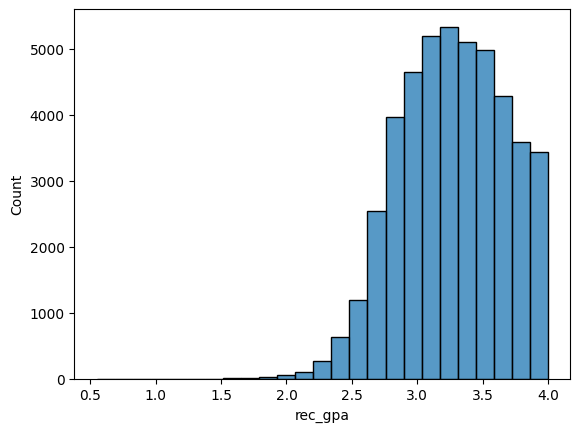

In [14]:
sns.histplot(df['rec_gpa'], bins=25)
plt.show()

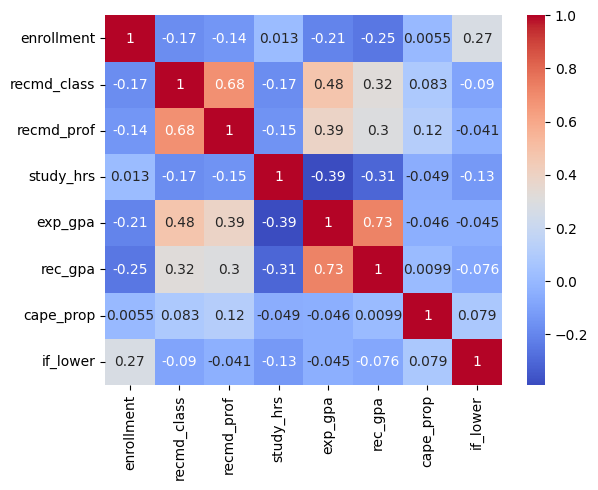

In [15]:
# Correlation
quan_data = df.drop(columns={
    'course_prefix',
    'Quarter',
    'season',
    #'if_lower'
})
correlation_matrix = quan_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Hypothesis Testing

### Regression Analysis

We will first perform a regular linear regression based on all the covariates we have obtained so far.

In [16]:
formula = 'rec_gpa ~ enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + season + cape_prop + if_lower'
model = smf.ols(formula, data=df).fit()
print(model.summary())
#course_prefix 要放进来吗

                            OLS Regression Results                            
Dep. Variable:                rec_gpa   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5478.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:06:37   Log-Likelihood:                -5344.3
No. Observations:               45393   AIC:                         1.071e+04
Df Residuals:                   45382   BIC:                         1.081e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0603      0.020      3.084   

Next， we compute the variance inflation factor (VIF) for each covariate to see if multicollinearity exists.

In [17]:
exog = model.model.exog
names = model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i):.3f}')
#Q: VIF 与 multicollinearity 的关系

VIF: season[T.SP]: 1.446
VIF: season[T.SS]: 1.350
VIF: season[T.WI]: 1.433
VIF: enrollment: 1.180
VIF: recmd_class: 2.093
VIF: recmd_prof: 1.906
VIF: study_hrs: 1.266
VIF: exp_gpa: 1.555
VIF: cape_prop: 1.081
VIF: if_lower: 1.145


This part checks if the students recieved GPA is significantly impacted compare to the gpa students received before the COVID period. It could be much better or worse. 

Definition of Covid in terms of UCSD Quarters: Quarters from Summer Session 2020 to SPing 2023. Both inclusive.

SS20 FA20 WI21 SP21 SS21 FA21 WI22 SP22 SS22 FA22 WI23 SP23

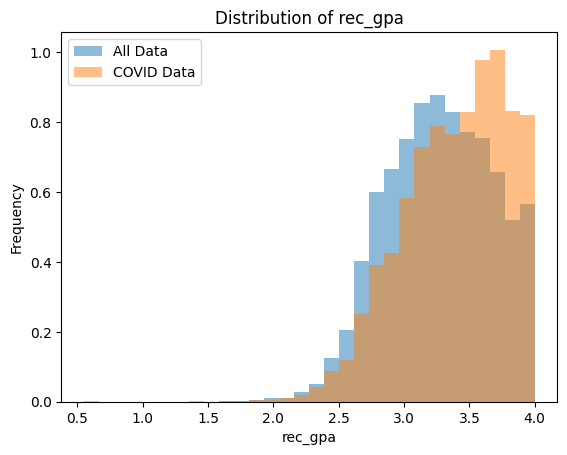

In [18]:
# Permutation test to see if the data is different

df_covid = df[df['Quarter'].apply(lambda x : x in ['SS20', 'FA20', 'WI21', 'SP21', 'SS21', 'FA21', 'WI22', 'SP22', 'SS22', 'FA22', 'WI23', 'SP23'])]
# df['rec_gpa'].mean() 3.27194
# df_covid['rec_gpa'].mean() 3.390616

plt.hist(df['rec_gpa'], bins=30, alpha=0.5, label='All Data',density=True)
plt.hist(df_covid['rec_gpa'], bins=30, alpha=0.5, label='COVID Data', density=True)

plt.title('Distribution of rec_gpa')
plt.xlabel('rec_gpa')
plt.ylabel('Frequency')
plt.legend()
plt.show()


It looks like the GPA during the Covid time is slightly higher than other time.  
In order to justify that, lets do a permutation test!

P-value: 0.2634


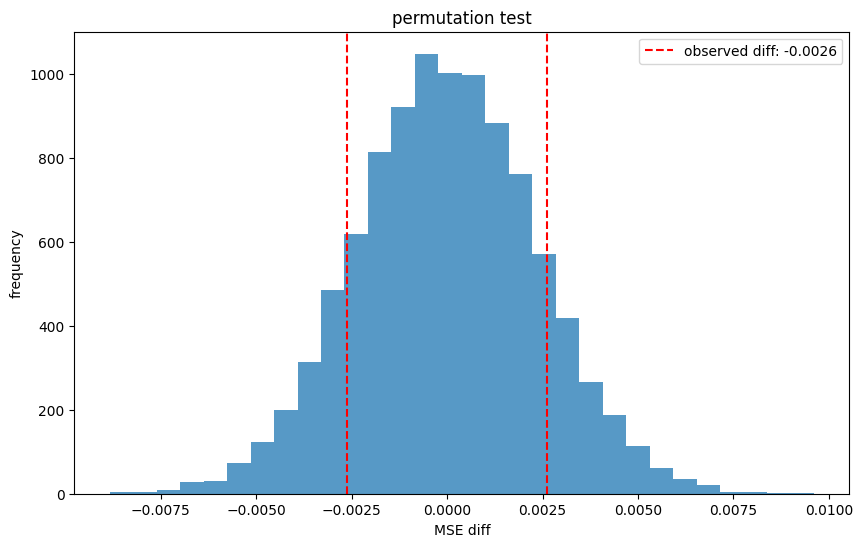

In [19]:
def mse_difference(data1, data2):
    return np.mean((data1 - np.mean(data2)) ** 2) - np.mean((data2 - np.mean(data1)) ** 2)


observed_mse_diff = mse_difference(df_covid['rec_gpa'], df[~df['Quarter'].isin(df_covid['Quarter'])]['rec_gpa'])

combined_data = np.concatenate([df_covid['rec_gpa'], df[~df['Quarter'].isin(df_covid['Quarter'])]['rec_gpa']])

num_permutations = 10000

permuted_mse_diffs = np.zeros(num_permutations)

for i in range(num_permutations):

    permuted_data = np.random.permutation(combined_data)

    permuted_sample1 = permuted_data[:len(df_covid)]
    permuted_sample2 = permuted_data[len(df_covid):]

    permuted_mse_diffs[i] = mse_difference(permuted_sample1, permuted_sample2)

p_value = np.mean(np.abs(permuted_mse_diffs) >= np.abs(observed_mse_diff))

# print(f'Observed mse diff: {observed_mse_diff}')
print(f'P-value: {p_value}')


plt.figure(figsize=(10, 6))
plt.hist(permuted_mse_diffs, bins=30, alpha=0.75)
plt.axvline(observed_mse_diff, color='red', linestyle='--', label=f'observed diff: {observed_mse_diff:.4f}')
plt.axvline(-observed_mse_diff, color='red', linestyle='--')
plt.title('permutation test')
plt.xlabel('MSE diff')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [20]:
X = df[['enrollment', 'recmd_class', 'recmd_prof', 'study_hrs', 'exp_gpa', 'cape_prop', 'if_lower']]
y = df['rec_gpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Correlation coefficient score: {r2}')

Mean Squared Error: 0.0756460153533001
Correlation coefficient score: 0.5389759482784987


In [21]:
# Prediction to a made-up date
new_data = [[30, 0.95, 0.90, 3.0, 3.75, 0.5, 1]]
predicted_gpa = model.predict(new_data)
print(f'Predicted GPA: {predicted_gpa[0]}')

Predicted GPA: 3.5464281238841213


c:\Users\84628\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [22]:
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
coefficients
# Which feature has the highest regression coefficient (influence)

,Coefficient
enrollment,-0.000452
recmd_class,-0.295665
recmd_prof,0.161327
study_hrs,-0.006257
exp_gpa,0.966874
cape_prop,0.083738
if_lower,-0.026043


According to our Linear Regression predicting model, Expected GPA in all features has

To identify the most important predictors and include them in the final regression model, we compare regression model formulas of all models we can create using subsets of the covariates and find the optimal model using BICs.

In [23]:
covariates = ['enrollment', 'recmd_class', 'recmd_prof', 'study_hrs', 'exp_gpa', 'season', 'cape_prop', 'if_lower']

In [24]:
formulas = []

from itertools import combinations

for i in range(1, len(covariates)+1):
    for subset in combinations(covariates, i):
            formula = "rec_gpa ~ " + " + ".join(subset)
            formulas.append(formula)

formulas[:10]

['rec_gpa ~ enrollment',
 'rec_gpa ~ recmd_class',
 'rec_gpa ~ recmd_prof',
 'rec_gpa ~ study_hrs',
 'rec_gpa ~ exp_gpa',
 'rec_gpa ~ season',
 'rec_gpa ~ cape_prop',
 'rec_gpa ~ if_lower',
 'rec_gpa ~ enrollment + recmd_class',
 'rec_gpa ~ enrollment + recmd_prof']

In [25]:
BICs = []
for formula in formulas:
    model = smf.ols(formula, df).fit()
    bic = -2 * model.llf + np.log(df.shape[0]) * len(model.params)
    BICs.append(bic)

# min(BICs) #10806.583574853334
# max(BICs) #46643.07376870214

In [26]:
min_index = np.argmin(BICs)
optimal_formula = formulas[min_index]
print(f'The formula of the optimal model is {optimal_formula}')

The formula of the optimal model is rec_gpa ~ enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + season + cape_prop + if_lower


Use backward selection to find the optimal model.

In [29]:
criterion = lambda formula, df: smf.ols(formula, df).fit().bic

def remove(df, selected_columns, criterion, response='rec_gpa'):
    worst_criterion = np.inf
    worst_column = None
    for column in selected_columns:
        new_columns = selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

In [30]:
remove(df, set(df.columns.drop('rec_gpa')), criterion)


('season', -260.08011102808996)

In [31]:
def backward(df, criterion, response='rec_gpa'):
    lst = ['rec_gpa', 'course_prefix', 'Quarter']
    selected_columns = set(df.columns.drop(lst))
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) > 0:
        potential_column, current_criterion = remove(df, selected_columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

In [32]:
backward_vars = backward(df, criterion, response='rec_gpa')
print(f'backward_vars: {backward_vars}')

Criterion: 10846.449023447009
backward_vars: {'enrollment', 'cape_prop', 'recmd_class', 'study_hrs', 'season', 'exp_gpa', 'recmd_prof'}


We apply the elastic net penalty

In [33]:
full_model = f' y ~ {" + ".join(covariates)}'
elastic_fit = smf.ols(full_model, df).fit_regularized("elastic_net", alpha=1.0, L1_wt=1.0)
print(elastic_fit.params)

Intercept       0.000000
season[T.SP]    0.000000
season[T.SS]    0.000000
season[T.WI]    0.000000
enrollment      0.002273
recmd_class     0.000000
recmd_prof      0.000000
study_hrs       0.081606
exp_gpa         0.661352
cape_prop       0.000000
if_lower        0.000000
dtype: float64


In [34]:
l1wt = 1.0
alphas = np.linspace(1e-3, 0.5, 200)
elastic_coef =[]
for alpha in alphas:
    elastic_fit = smf.ols(full_model, df).fit_regularized('elastic_net', alpha, l1wt)
    elastic_coef.append(elastic_fit.params[1:])

In [35]:
elastic_coef = pd.DataFrame(elastic_coef, alphas)
elastic_coef.head()

,season[T.SP],season[T.SS],season[T.WI],enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,cape_prop,if_lower
0.001000,0.042703,0.0,0.011212,-0.000775,0.368027,0.136758,-0.044661,0.188217,-0.137045,-0.044310
0.003508,0.032114,0.0,0.000000,-0.000749,0.356036,0.131472,-0.039803,0.213481,-0.067306,-0.033417
0.006015,0.026452,0.0,0.000000,-0.000728,0.341983,0.126073,-0.034907,0.238147,0.000000,-0.021114
0.008523,0.019333,0.0,0.000000,-0.000709,0.331944,0.123522,-0.030383,0.261303,0.000000,-0.006800
0.011030,0.011783,0.0,0.000000,-0.000680,0.321837,0.122492,-0.026024,0.283801,0.000000,0.000000


Text(0, 0.5, 'coefficient')

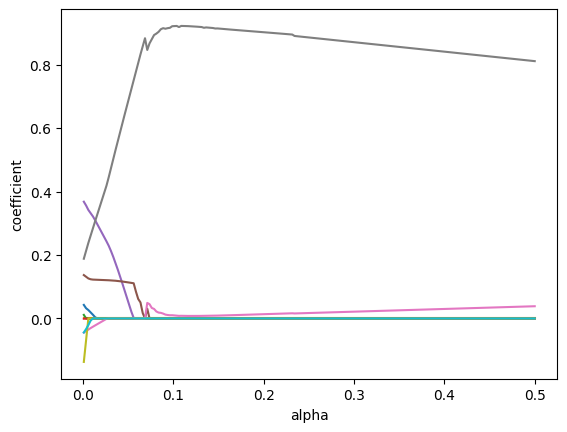

In [36]:
fig, ax = plt.subplots()
for column in elastic_coef.columns:
    ax.plot(alphas, elastic_coef[column], label=column)
ax.set_xlabel('alpha')
ax.set_ylabel('coefficient')

In [37]:
elastic_fit = smf.ols(full_model, df).fit_regularized('elastic_net', 0.3, 1.0)
print(elastic_fit.params[elastic_fit.params != 0])

enrollment    0.000363
study_hrs     0.021322
exp_gpa       0.870938
dtype: float64
